# Dask imaging demonstration

This notebook explores the use of dask for parallelisation. We work through the steps of imaging using dask, ending up with a major/minor cycle algorithm without and with selfcalibration.

The functions used are in pipelines/dask_graphs.py

In [1]:
%matplotlib inline

import os
import sys

from dask import delayed
from distributed import progress

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.calibration.solvers import solve_gaintable
from arl.calibration.operations import apply_gaintable, create_gaintable_from_blockvisibility
from arl.data.data_models import Image, BlockVisibility, Visibility
from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.operations import create_blockvisibility, create_visibility_from_rows, \
    copy_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.operations import show_image, export_image_to_fits, qa_image, copy_image
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, simulate_gaintable
from arl.fourier_transforms.ftprocessor import predict_2d, invert_2d, \
    normalize_sumwt, create_image_from_visibility, \
    predict_skycomponent_blockvisibility, residual_image, invert_timeslice_single, \
    predict_timeslice_single, predict_timeslice_single, advise_wide_field
from arl.pipelines.dask_init import get_dask_Client, kill_dask_Client
from arl.pipelines.dask_graphs import create_invert_graph, create_deconvolve_graph, \
    create_continuum_imaging_graph, create_ical_graph, create_residual_graph

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
c=get_dask_Client()
c.scheduler_info()

Creating Dask Client


{'address': 'tcp://127.0.0.1:60298',
 'id': 'e1994250-4c4e-11e7-adc0-a0999b0524c5',
 'services': {'bokeh': 8787},
 'type': 'Scheduler',
 'workers': {'tcp://127.0.0.1:60303': {'host': '127.0.0.1',
   'last-seen': 1496928736.581204,
   'local_directory': '/var/folders/hw/kw6kvgqs7mn49ldhmr4wcfch0000gn/T/nanny-d7mpxv9k',
   'memory_limit': 1288490188.0,
   'name': 'tcp://127.0.0.1:60303',
   'ncores': 1,
   'services': {'bokeh': 60305, 'nanny': 60299},
   'time-delay': 0.00500798225402832},
  'tcp://127.0.0.1:60304': {'host': '127.0.0.1',
   'last-seen': 1496928736.589683,
   'local_directory': '/var/folders/hw/kw6kvgqs7mn49ldhmr4wcfch0000gn/T/nanny-danbf3w4',
   'memory_limit': 1288490188.0,
   'name': 'tcp://127.0.0.1:60304',
   'ncores': 1,
   'services': {'bokeh': 60307, 'nanny': 60300},
   'time-delay': 0.004191875457763672},
  'tcp://127.0.0.1:60306': {'host': '127.0.0.1',
   'last-seen': 1496928736.5945091,
   'local_directory': '/var/folders/hw/kw6kvgqs7mn49ldhmr4wcfch0000gn/T/nan

We create the visibility and fill in values with the transform of a number of point sources. 

In [3]:
def ingest_visibility(freq=1e8, chan_width=1e6, time=0.0):
    lowcore = create_named_configuration('LOWBD2')
    times = [time]
    frequency = numpy.array([freq])
    channel_bandwidth = numpy.array([chan_width])

    phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
    vt = create_blockvisibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                                weight=1.0, phasecentre=phasecentre, 
                                polarisation_frame=PolarisationFrame("stokesI"))
    npixel = 1024
    cellsize=0.00001
    model = create_image_from_visibility(vt, npixel=npixel, cellsize=cellsize, npol=1, frequency=vt.frequency,
                                        polarisation_frame=PolarisationFrame("stokesI"))
    flux = numpy.array([[100.0]])
    facets = 4

    spacing_pixels = npixel // facets
    spacing = 180.0 * cellsize * spacing_pixels / numpy.pi
    centers = -1.5, -0.5, +0.5, +1.5
    comps = list()
    for iy in centers:
        for ix in centers:
            pra =  int(round(npixel // 2 + ix * spacing_pixels - 1))
            pdec = int(round(npixel // 2 + iy * spacing_pixels - 1))
            sc = pixel_to_skycoord(pra, pdec, model.wcs)
            comps.append(create_skycomponent(flux=flux, frequency=vt.frequency, direction=sc, 
                                             polarisation_frame=PolarisationFrame("stokesI")))
    predict_skycomponent_blockvisibility(vt, comps)
    gt = create_gaintable_from_blockvisibility(vt)
    gt = simulate_gaintable(gt, phase_error=1.0, amplitude_error=0.0)
    vt = apply_gaintable(vt, gt)
    return vt

In [4]:
nfreqwin=7
vis_graph_list=list()
for freq in numpy.linspace(0.8e8,1.2e8,nfreqwin):
    vis_graph_list.append(delayed(ingest_visibility)(freq))

Get the Local Sky Model. It is empty in this case.

In [5]:
def get_LSM(vt, npixel = 1024, cellsize=0.00001):
    model = create_image_from_visibility(vt, npixel=npixel, cellsize=cellsize, npol=1, frequency=vt.frequency,
                                        polarisation_frame=PolarisationFrame("stokesI"))
    return model

In [6]:
nvis=len(vis_graph_list)

model_graph = delayed(get_LSM)(vis_graph_list[nvis//2])

psf_graph=create_invert_graph(vis_graph_list, model_graph, dopsf=True, 
                              invert_single=invert_timeslice_single, normalize=True)

We now create and visualize a graph to perform a deconvolution using the summed dirty image and PSF.

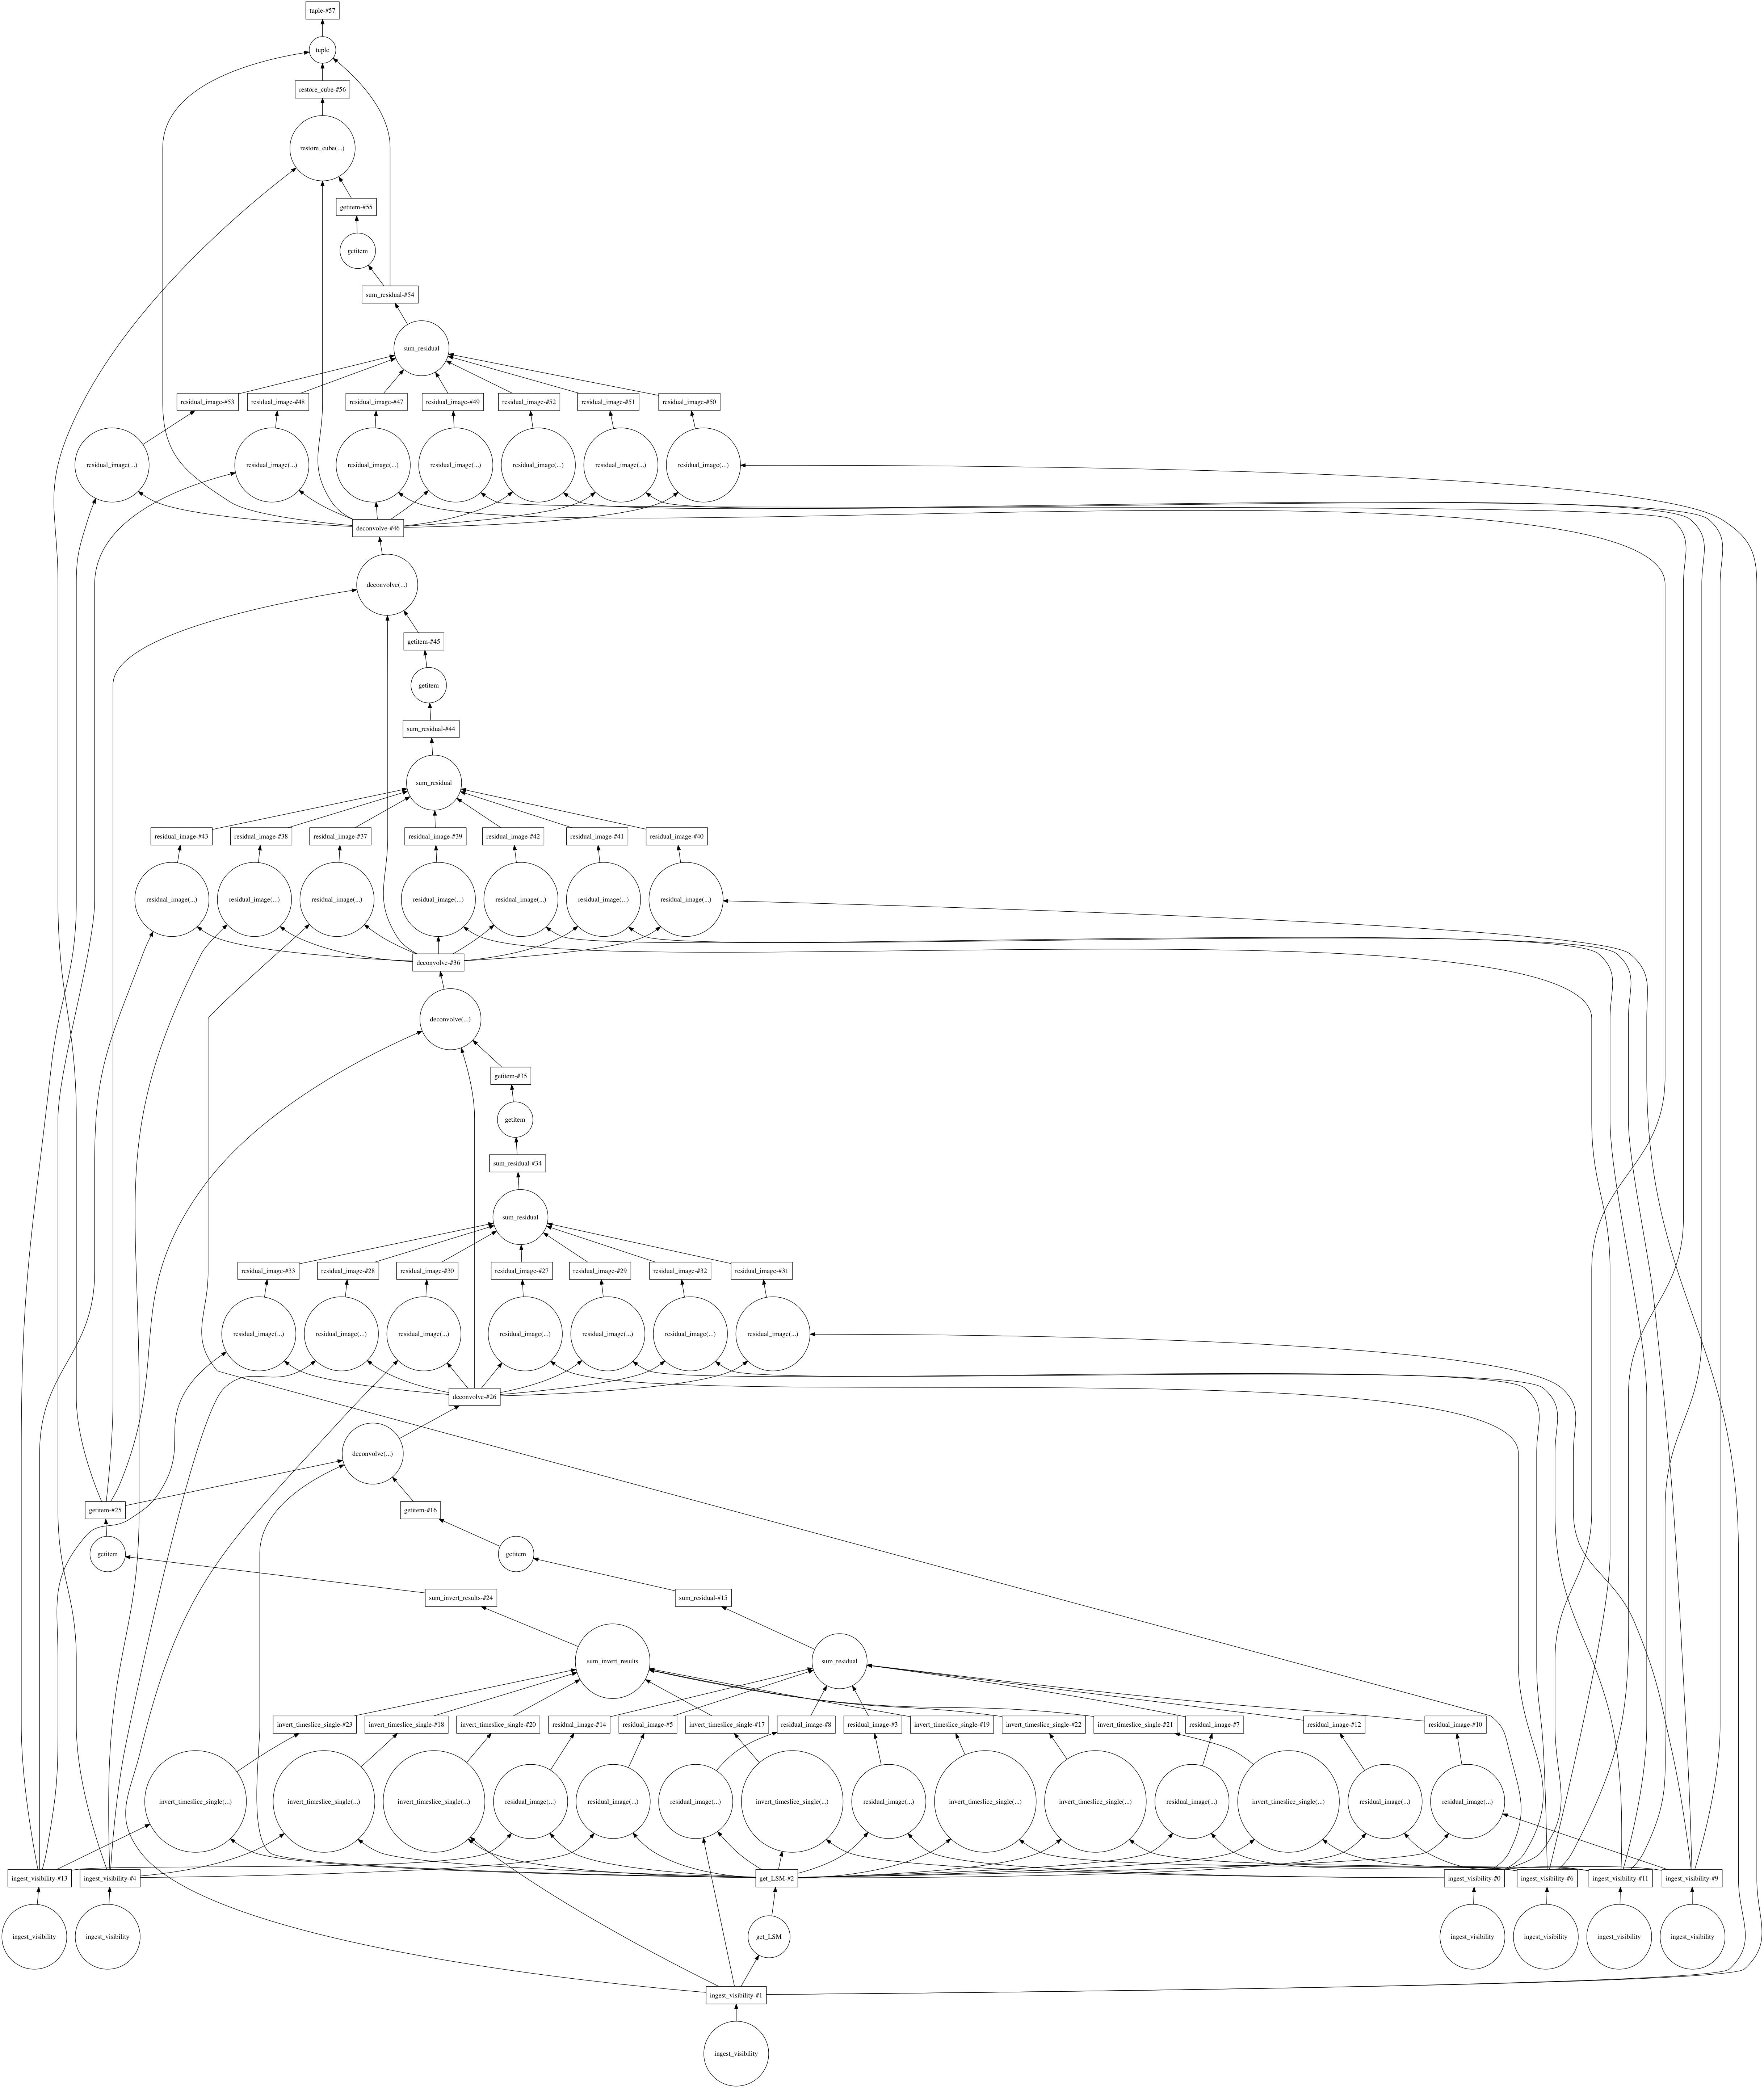

In [8]:
continuum_imaging_graph = create_continuum_imaging_graph(vis_graph_list, model_graph=model_graph, 
                                                         algorithm='hogbom', niter=1000, fractional_threshold=0.1,
                                                         threshold=1.0, nmajor=3, gain=0.1)
continuum_imaging_graph.visualize()

In [9]:
future=c.compute(continuum_imaging_graph)
progress(future)

Quality assessment:
	Origin: qa_image
	Context: Clean clean image - no selfcal
	Data:
		shape: (1, 1, 1024, 1024)
		max: 33.9792337744
		min: -1.43921163952
		rms: 0.110174142811
		sum: 586.835605161
		medianabs: 0.0
		median: 0.0



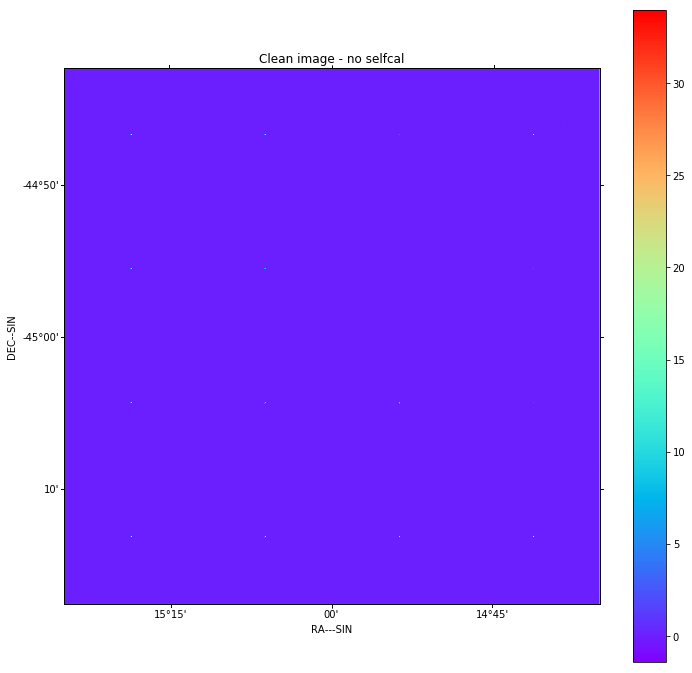

Quality assessment:
	Origin: qa_image
	Context: Restored clean image - no selfcal
	Data:
		shape: (1, 1, 1024, 1024)
		max: 37.4420835054
		min: -2.64447565001
		rms: 0.944756100233
		sum: -13645.7854323
		medianabs: 0.314699249093
		median: -0.0572147089125



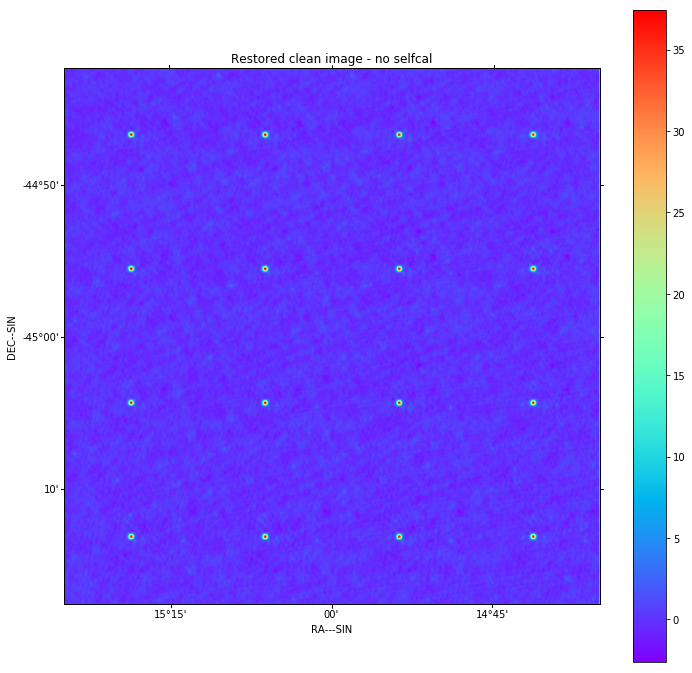

Quality assessment:
	Origin: qa_image
	Context: Residual clean image - no selfcal
	Data:
		shape: (1, 1, 1024, 1024)
		max: 1.23854475966
		min: -1.24336186708
		rms: 0.436324035355
		sum: -51771.0552166
		medianabs: 0.30788981401
		median: -0.0582829201796



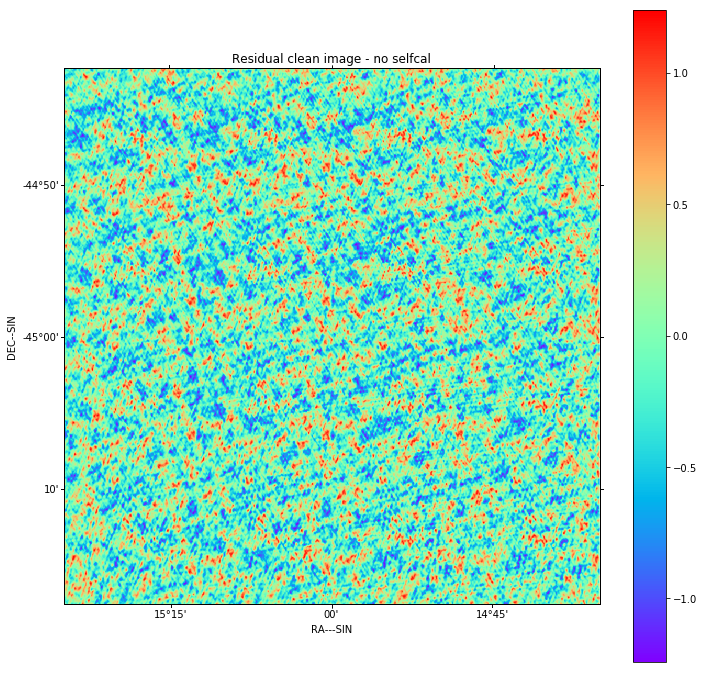

In [10]:
deconvolved = future.result()[0]
residual = future.result()[1]
restored = future.result()[2]

f=show_image(deconvolved, title='Clean image - no selfcal')
print(qa_image(deconvolved, context='Clean clean image - no selfcal'))
plt.show()

f=show_image(restored, title='Restored clean image - no selfcal')
print(qa_image(restored, context='Restored clean image - no selfcal'))
plt.show()

f=show_image(residual[0], title='Residual clean image - no selfcal')
print(qa_image(residual[0], context='Residual clean image - no selfcal'))
plt.show()

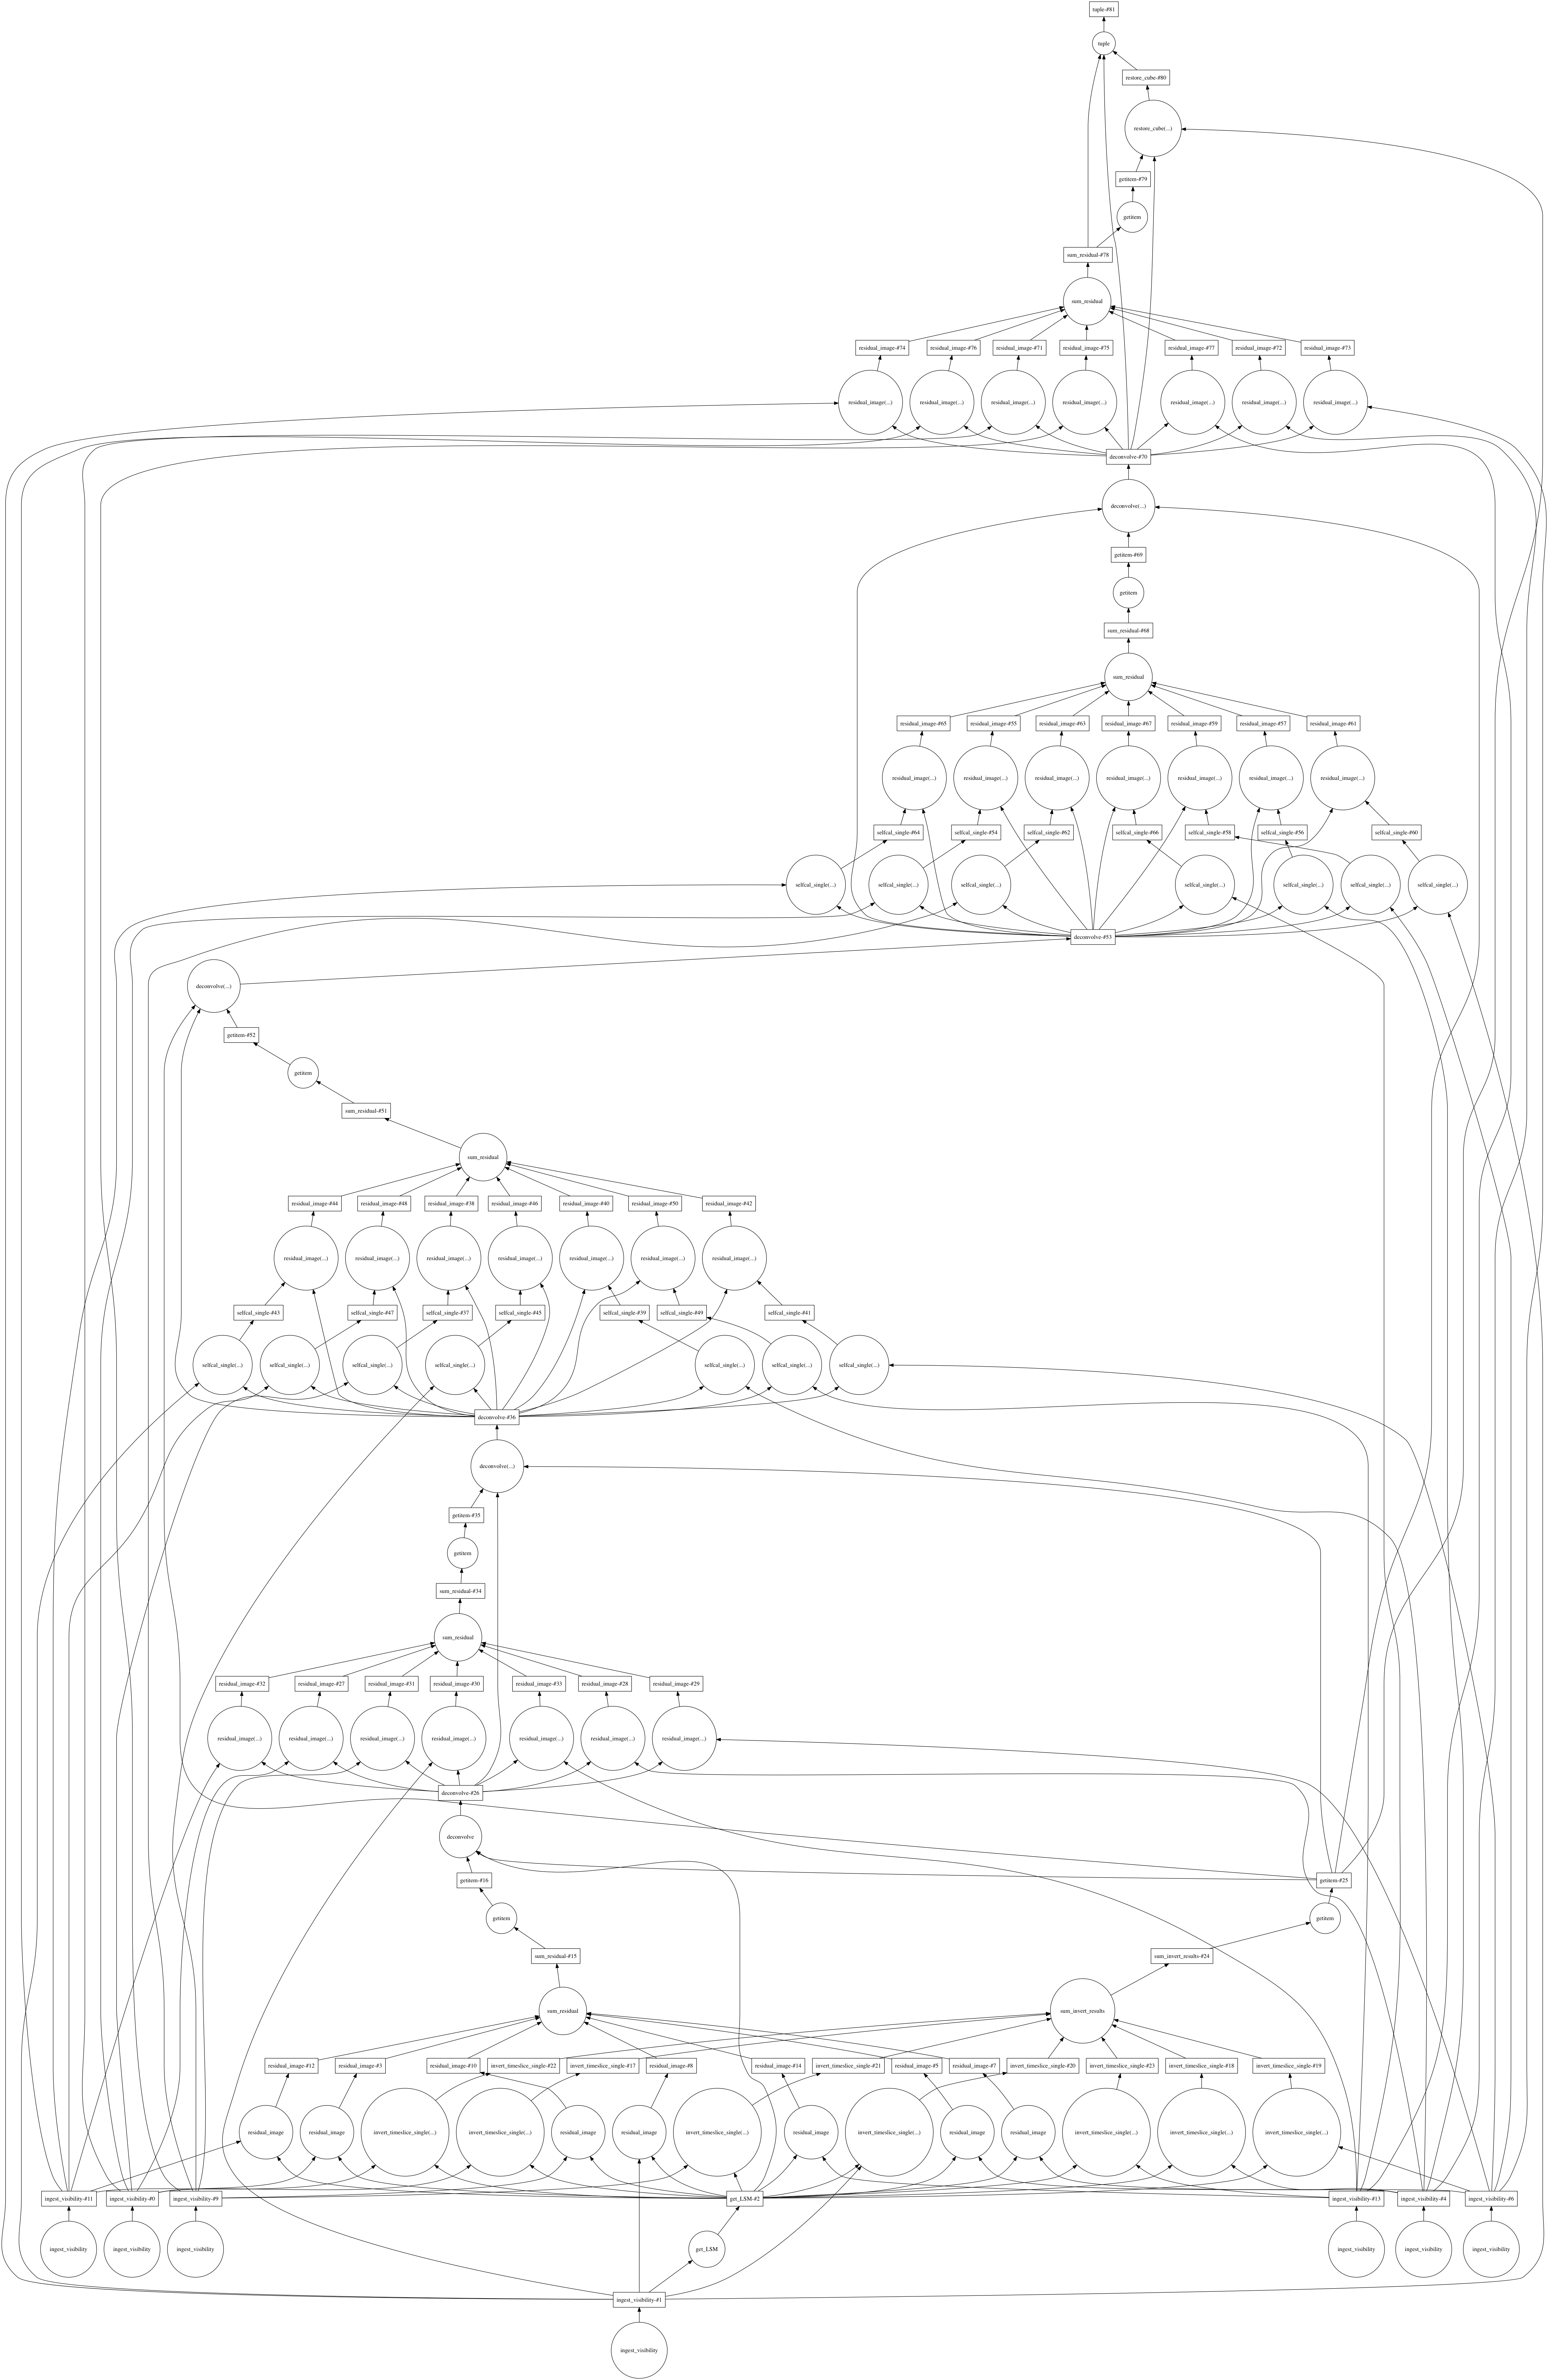

In [11]:
ical_graph = create_ical_graph(vis_graph_list, model_graph=model_graph,
                               algorithm='hogbom', niter=1000, fractional_threshold=0.1,
                               threshold=1.0, nmajor=3, first_selfcal=1, gain=0.1)
g=ical_graph.visualize(filename='imaging-dask-ical-graph-%d' % (nfreqwin), format='svg')
ical_graph.visualize()

In [12]:
future=c.compute(ical_graph)
progress(future)

In [ ]:
deconvolved = future.result()[0]
residual = future.result()[1]
restored = future.result()[2]

f=show_image(deconvolved, title='Clean image')
print(qa_image(deconvolved, context='Clean clean image'))
plt.show()

f=show_image(restored, title='Restored clean image')
print(qa_image(restored, context='Restored clean image'))
plt.show()

f=show_image(residual[0], title='Residual clean image')
print(qa_image(residual[0], context='Residual clean image'))
plt.show()

In [ ]:
c.shutdown()